In [228]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import contextily as ctx

In [229]:
start_date = "2021-06-25"
end_date = "2021-09-15"

# Data source 
# https://data.nsw.gov.au/nsw-covid-19-data/cases
confirmed_cases_url = "https://data.nsw.gov.au/data/dataset/aefcde60-3b0c-4bc0-9af1-6fe652944ec2/resource/21304414-1ff1-4243-a5d2-f52778048b29/download/confirmed_cases_table1_location.csv"

# load data from CSV file
cases_df = pd.read_csv(confirmed_cases_url)
cases_df.notification_date = pd.to_datetime(cases_df.notification_date)

# remove last date from data since it is incomplete
cases_df = cases_df[cases_df.notification_date < cases_df.notification_date.max()]

# filter by start_date and end_date
cases_df = cases_df[(cases_df.notification_date >= start_date) & (cases_df.notification_date <= end_date)]
cases_df

,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
5512,2021-06-25,2017,X700,Sydney,17200.0,Sydney (C)
5513,2021-06-25,2031,X720,South Eastern Sydney,16550.0,Randwick (C)
5514,2021-06-25,2035,X720,South Eastern Sydney,16550.0,Randwick (C)
5515,2021-06-25,2026,X720,South Eastern Sydney,18050.0,Waverley (A)
5516,2021-06-25,2026,X720,South Eastern Sydney,18050.0,Waverley (A)
...,...,...,...,...,...,...
13362,2021-08-14,2285,X800,Hunter New England,14650.0,Lake Macquarie (C)
13363,2021-08-14,2148,X740,Western Sydney,10750.0,Blacktown (C)
13364,2021-08-14,2770,X740,Western Sydney,10750.0,Blacktown (C)
13365,2021-08-14,2148,X740,Western Sydney,10750.0,Blacktown (C)


In [230]:
poa_population = pd.read_csv("data/census/poa_population.csv").set_index("Unnamed: 0")
# Set population for postcode manually (suburb population has grown significantly since 2016 Census)
poa_population.loc['POA2174']['Tot_P_P'] = 5409
poa_population

,ASGS_Code_2016,Tot_P_P
Unnamed: 0,,
POA2000,2000,27411
POA2006,2006,1259
POA2007,2007,8845
POA2008,2008,11712
POA2009,2009,12813
...,...,...
POA2877,2877,3883
POA2878,2878,372
POA2879,2879,638


In [231]:
poa_total_cases_df = cases_df.groupby(by=["postcode"]).size().to_frame("case_count").reset_index()
poa_total_cases_df = poa_total_cases_df[poa_total_cases_df.postcode != "Masked"]
poa_total_cases_df = poa_total_cases_df.astype({'postcode': 'int32'})
poa_total_cases_df

,postcode,case_count
0,1730,1
1,2000,21
2,2008,1
3,2009,17
4,2010,12
...,...,...
254,2832,4
255,2847,1
256,2850,2
257,2866,1


In [232]:
poa_total_cases_df = pd.merge(poa_total_cases_df, poa_population[["ASGS_Code_2016", "Tot_P_P"]], 
                              left_on="postcode", right_on="ASGS_Code_2016")[["postcode", "case_count", "Tot_P_P"]]



poa_total_cases_df = poa_total_cases_df.rename(columns={ "Tot_P_P": "population"})
poa_total_cases_df

poa_total_cases_df["cases_per_1000"] = poa_total_cases_df.case_count / poa_total_cases_df.population * 1000

poa_total_cases_df = poa_total_cases_df.sort_values("cases_per_1000", ascending=False)

poa_total_cases_df.head(20)

,postcode,case_count,population,cases_per_1000
106,2165,496,42444,11.685986
124,2194,230,24541,9.372071
119,2179,57,6530,8.728943
116,2176,377,47809,7.885545
104,2163,71,9590,7.403545
125,2195,201,27154,7.402224
105,2164,141,19624,7.185079
103,2162,124,18622,6.658791
120,2190,165,25566,6.453884
127,2197,58,9069,6.395413


In [233]:
poa_total_cases_df[poa_total_cases_df.postcode == 2233]

,postcode,case_count,population,cases_per_1000
156,2233,11,29498,0.372907


In [234]:
poa_total_cases_df[poa_total_cases_df.postcode == 2210]

,postcode,case_count,population,cases_per_1000
138,2210,42,30586,1.373177


In [235]:
postcodes_df = gpd.read_file("data/geo/greater_sydney_postcodes.json").to_crs(epsg=4326)
postcodes_df = postcodes_df.astype({'POA_NAME16': 'int32'})
postcodes_df

,POA_CODE16,POA_NAME16,AREASQKM16,geometry
0,2006,2006,0.6780,"POLYGON ((151.19142 -33.88470, 151.19162 -33.8..."
1,2007,2007,0.5588,"POLYGON ((151.19469 -33.88090, 151.19461 -33.8..."
2,2008,2008,0.8450,"POLYGON ((151.19399 -33.88655, 151.19441 -33.8..."
3,2009,2009,0.9325,"POLYGON ((151.18869 -33.86635, 151.18908 -33.8..."
4,2010,2010,2.1733,"POLYGON ((151.21075 -33.87860, 151.21102 -33.8..."
...,...,...,...,...
202,2766,2766,27.2385,"POLYGON ((150.83116 -33.76492, 150.83065 -33.7..."
203,2767,2767,10.1088,"POLYGON ((150.85568 -33.76181, 150.85563 -33.7..."
204,2768,2768,9.0193,"POLYGON ((150.91324 -33.72664, 150.91280 -33.7..."
205,2769,2769,4.6535,"POLYGON ((150.89422 -33.70375, 150.89448 -33.7..."


In [236]:
poa_total_cases_df = pd.merge(postcodes_df, poa_total_cases_df, left_on="POA_NAME16", right_on="postcode")

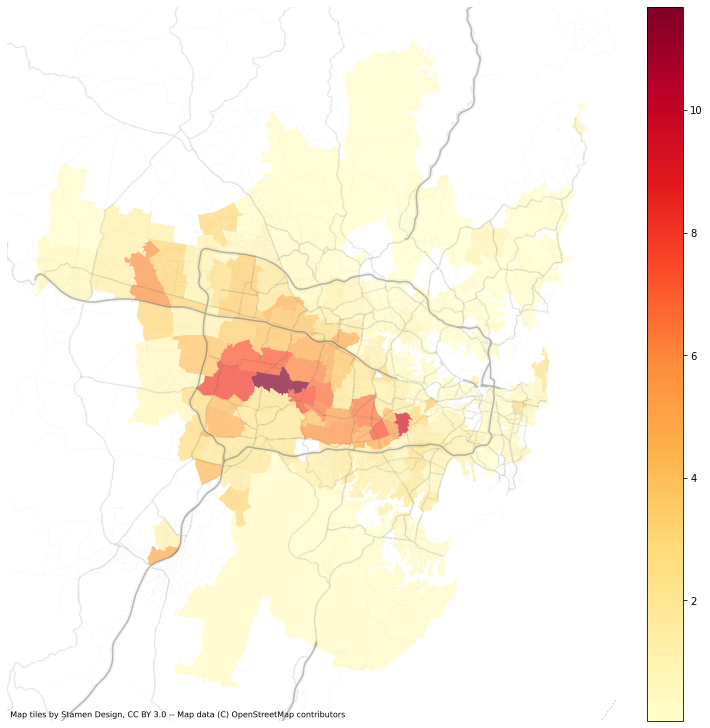

In [237]:
fig = plt.figure(constrained_layout=True, figsize=(10,10))
gs = GridSpec(1, 1, figure=fig)
ax_map = fig.add_subplot(gs[:, :])
ax_map.set_axis_off()
poa_total_cases_df.to_crs(epsg=3857).plot(ax=ax_map, cmap='YlOrRd', column='cases_per_1000', 
            k=4, alpha=0.7, legend=True, clim=100) #, scheme='QUANTILES' cmap='viridis'

ctx.add_basemap(ax_map, zoom=11, source=ctx.providers.Stamen.TonerLines, alpha=.3)
#ctx.add_basemap(ax_map, zoom=11, source=ctx.providers.Stamen.TonerLabels)